In [2]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [3]:
ee.Initialize()

In [4]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [ ]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment
from BackGround_modules.Class_4_Create_Sample_Classification_instancs import Make_Sample_Classification

##### Define_Basic_Parameters

In [ ]:
# define the year_name for test, here choose these years because they represent
# Landsat8/7/5 respectively
year_name = ['2017_2019','2011_2013', '2008_2010']
percent_value = [1,2,3,5,7,10,20,30,50,70,100]
tree_num = [1] + list(range(10,121,10))

combination_name = ['Landsat',
                    'Fourier',
                    'Landsat_Fourier',
                    'Landsat_Mean',
                    'Fourier_Mean',
                    'Landsat_Fourier_Mean',
                    'Landsat_Fourier_Climate',
                    'Landsat_Fourier_Terrain',
                    'Landsat_Fourier_Terrain_Climate']

#### Calculate the band_combination accuracy using [Invariant_traning_sample] with different percentage reduction

Produce classification_instances

In [6]:
# define the path to point_with_value GEE-Path
path = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized_Climate'

# instantiate the combo_instance dictionary
Combo_instance_with_village = {}

# Create sample_classification instances through [year] --> [Percent] --> [band_combination] --> [Tree]
for year in year_name:
    
    Invarient_sample = ee.FeatureCollection(f'{path}/Invarient_ext_Img_{year}')
    
    # import samples
    Invarient_built      = Invarient_sample.filterMetadata('Built','equals',1)
    Invarient_non_Built  = Invarient_sample.filterMetadata('Built','equals',0)
       
    for pct in percent_value:
        
        # Create percentage_reduced samples, only use non-built points from verified points
        Subset_Invarient_built     = Make_Sample_Classification.Step_1_Subset_sample(Invarient_built,pct)
        Subset_Invarient_non_Built = Make_Sample_Classification.Step_1_Subset_sample(Invarient_non_Built,pct)
        
        # Merge Verified_points with Zone_points
        Sample_merge = Subset_Invarient_built.merge(Subset_Invarient_non_Built)
        
        # Get the band_combo names
        Band_combo   = Make_Sample_Classification.Step_2_Create_Band_Combo(Sample_merge)
        
        for combo in Band_combo:
            Accuracy_instance = Make_Sample_Classification.\
                                Step_3_Create_Classification_Instance(year,Sample_merge,
                                                                      combo,tree_num,
                                                                      pct,classificaiton_func = Classification ) 
            Combo_instance_with_village.update(Accuracy_instance)
        

Percetage coresponded size is 141
Percetage coresponded size is 87
Classification of 2017_2019_Landsat_pct_001_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_001_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_001_tree_0001 completed!
Classification of 2017_

Percetage coresponded size is 283
Percetage coresponded size is 174
Classification of 2017_2019_Landsat_pct_002_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_002_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_002_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 425
Percetage coresponded size is 261
Classification of 2017_2019_Landsat_pct_003_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_003_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_003_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 709
Percetage coresponded size is 435
Classification of 2017_2019_Landsat_pct_005_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_005_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_005_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 993
Percetage coresponded size is 609
Classification of 2017_2019_Landsat_pct_007_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_007_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_007_tree_0001 completed!
Classification of 2017

Percetage coresponded size is 1419
Percetage coresponded size is 870
Classification of 2017_2019_Landsat_pct_010_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_010_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_010_tree_0001 completed!
Classification of 201

Percetage coresponded size is 2838
Percetage coresponded size is 1741
Classification of 2017_2019_Landsat_pct_020_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_020_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_020_tree_0001 completed!
Classification of 20

Percetage coresponded size is 4257
Percetage coresponded size is 2611
Classification of 2017_2019_Landsat_pct_030_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_030_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_030_tree_0001 completed!
Classification of 20

Percetage coresponded size is 7095
Percetage coresponded size is 4353
Classification of 2017_2019_Landsat_pct_050_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_050_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 9933
Percetage coresponded size is 6094
Classification of 2017_2019_Landsat_pct_070_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_070_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_070_tree_0001 completed!
Classification of 20

Percetage coresponded size is 14190
Percetage coresponded size is 8706
Classification of 2017_2019_Landsat_pct_100_tree_0001 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0010 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0020 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0030 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0040 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0050 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0060 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0070 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0080 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0090 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0100 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0110 completed!
Classification of 2017_2019_Landsat_pct_100_tree_0120 completed!
Classification of 2017_2019_Fourier_pct_100_tree_0001 completed!
Classification of 2

Percetage coresponded size is 141
Percetage coresponded size is 87
Classification of 2011_2013_Landsat_pct_001_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_001_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_001_tree_0001 completed!
Classification of 2011_

Percetage coresponded size is 283
Percetage coresponded size is 174
Classification of 2011_2013_Landsat_pct_002_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_002_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_002_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 425
Percetage coresponded size is 261
Classification of 2011_2013_Landsat_pct_003_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_003_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_003_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 709
Percetage coresponded size is 435
Classification of 2011_2013_Landsat_pct_005_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_005_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_005_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 993
Percetage coresponded size is 609
Classification of 2011_2013_Landsat_pct_007_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_007_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_007_tree_0001 completed!
Classification of 2011

Percetage coresponded size is 1419
Percetage coresponded size is 870
Classification of 2011_2013_Landsat_pct_010_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_010_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_010_tree_0001 completed!
Classification of 201

Percetage coresponded size is 2838
Percetage coresponded size is 1741
Classification of 2011_2013_Landsat_pct_020_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_020_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_020_tree_0001 completed!
Classification of 20

Percetage coresponded size is 4257
Percetage coresponded size is 2611
Classification of 2011_2013_Landsat_pct_030_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_030_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_030_tree_0001 completed!
Classification of 20

Percetage coresponded size is 7095
Percetage coresponded size is 4353
Classification of 2011_2013_Landsat_pct_050_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_050_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 9933
Percetage coresponded size is 6094
Classification of 2011_2013_Landsat_pct_070_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_070_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_070_tree_0001 completed!
Classification of 20

Percetage coresponded size is 14190
Percetage coresponded size is 8706
Classification of 2011_2013_Landsat_pct_100_tree_0001 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0010 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0020 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0030 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0040 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0050 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0060 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0070 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0080 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0090 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0100 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0110 completed!
Classification of 2011_2013_Landsat_pct_100_tree_0120 completed!
Classification of 2011_2013_Fourier_pct_100_tree_0001 completed!
Classification of 2

Percetage coresponded size is 141
Percetage coresponded size is 87
Classification of 2008_2010_Landsat_pct_001_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_001_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_001_tree_0001 completed!
Classification of 2008_

Percetage coresponded size is 283
Percetage coresponded size is 174
Classification of 2008_2010_Landsat_pct_002_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_002_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_002_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 425
Percetage coresponded size is 261
Classification of 2008_2010_Landsat_pct_003_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_003_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_003_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 709
Percetage coresponded size is 435
Classification of 2008_2010_Landsat_pct_005_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_005_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_005_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 993
Percetage coresponded size is 609
Classification of 2008_2010_Landsat_pct_007_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_007_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_007_tree_0001 completed!
Classification of 2008

Percetage coresponded size is 1419
Percetage coresponded size is 870
Classification of 2008_2010_Landsat_pct_010_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_010_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_010_tree_0001 completed!
Classification of 200

Percetage coresponded size is 2838
Percetage coresponded size is 1741
Classification of 2008_2010_Landsat_pct_020_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_020_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_020_tree_0001 completed!
Classification of 20

Percetage coresponded size is 4257
Percetage coresponded size is 2611
Classification of 2008_2010_Landsat_pct_030_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_030_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_030_tree_0001 completed!
Classification of 20

Percetage coresponded size is 7095
Percetage coresponded size is 4353
Classification of 2008_2010_Landsat_pct_050_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_050_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_050_tree_0001 completed!
Classification of 20

Percetage coresponded size is 9933
Percetage coresponded size is 6094
Classification of 2008_2010_Landsat_pct_070_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_070_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_070_tree_0001 completed!
Classification of 20

Percetage coresponded size is 14190
Percetage coresponded size is 8706
Classification of 2008_2010_Landsat_pct_100_tree_0001 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0010 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0020 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0030 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0040 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0050 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0060 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0070 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0080 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0090 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0100 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0110 completed!
Classification of 2008_2010_Landsat_pct_100_tree_0120 completed!
Classification of 2008_2010_Fourier_pct_100_tree_0001 completed!
Classification of 2

#### Produce classification_instances <br>

In [7]:
# innitialize the accuracy dict
Combo_acc_with_village = {}

# innitilize operation flag to report the process
Opts_flag  = 0
Opts_tatal = len(year_name) * len(combination_name) * len(percent_value) * len(tree_num)

# unpack the combo_instance through [year] --> [band_combination] --> [Percent] --> [Tree]
for year in year_name:
    for name in combination_name:
        for pct in percent_value:
            for tree in tree_num:

                Opts_flag+=1

                Combo_acc_with_village[(year,name,pct,tree)] = Accuracy_assesment(Combo_instance_with_village[(year,name,pct,tree)])\
                                              .Stp_1_Calculate_Accuracy()
                # print out the process
                print(f'{year}_{name}_pct_{pct:03}_tree_{tree:03} accuracy computation finished! ==>{Opts_flag:04}/{Opts_tatal}')
            print('_________________')

2017_2019_Landsat_pct_001_tree_001 accuracy computation finished! ==>0001/3861
2017_2019_Landsat_pct_001_tree_010 accuracy computation finished! ==>0002/3861
2017_2019_Landsat_pct_001_tree_020 accuracy computation finished! ==>0003/3861
2017_2019_Landsat_pct_001_tree_030 accuracy computation finished! ==>0004/3861
2017_2019_Landsat_pct_001_tree_040 accuracy computation finished! ==>0005/3861
2017_2019_Landsat_pct_001_tree_050 accuracy computation finished! ==>0006/3861
2017_2019_Landsat_pct_001_tree_060 accuracy computation finished! ==>0007/3861
2017_2019_Landsat_pct_001_tree_070 accuracy computation finished! ==>0008/3861
2017_2019_Landsat_pct_001_tree_080 accuracy computation finished! ==>0009/3861
2017_2019_Landsat_pct_001_tree_090 accuracy computation finished! ==>0010/3861
2017_2019_Landsat_pct_001_tree_100 accuracy computation finished! ==>0011/3861
2017_2019_Landsat_pct_001_tree_110 accuracy computation finished! ==>0012/3861
2017_2019_Landsat_pct_001_tree_120 accuracy computat

2017_2019_Landsat_pct_030_tree_120 accuracy computation finished! ==>0104/3861
_________________
2017_2019_Landsat_pct_050_tree_001 accuracy computation finished! ==>0105/3861
2017_2019_Landsat_pct_050_tree_010 accuracy computation finished! ==>0106/3861
2017_2019_Landsat_pct_050_tree_020 accuracy computation finished! ==>0107/3861
2017_2019_Landsat_pct_050_tree_030 accuracy computation finished! ==>0108/3861
2017_2019_Landsat_pct_050_tree_040 accuracy computation finished! ==>0109/3861
2017_2019_Landsat_pct_050_tree_050 accuracy computation finished! ==>0110/3861
2017_2019_Landsat_pct_050_tree_060 accuracy computation finished! ==>0111/3861
2017_2019_Landsat_pct_050_tree_070 accuracy computation finished! ==>0112/3861
2017_2019_Landsat_pct_050_tree_080 accuracy computation finished! ==>0113/3861
2017_2019_Landsat_pct_050_tree_090 accuracy computation finished! ==>0114/3861
2017_2019_Landsat_pct_050_tree_100 accuracy computation finished! ==>0115/3861
2017_2019_Landsat_pct_050_tree_110

2017_2019_Fourier_pct_007_tree_100 accuracy computation finished! ==>0206/3861
2017_2019_Fourier_pct_007_tree_110 accuracy computation finished! ==>0207/3861
2017_2019_Fourier_pct_007_tree_120 accuracy computation finished! ==>0208/3861
_________________
2017_2019_Fourier_pct_010_tree_001 accuracy computation finished! ==>0209/3861
2017_2019_Fourier_pct_010_tree_010 accuracy computation finished! ==>0210/3861
2017_2019_Fourier_pct_010_tree_020 accuracy computation finished! ==>0211/3861
2017_2019_Fourier_pct_010_tree_030 accuracy computation finished! ==>0212/3861
2017_2019_Fourier_pct_010_tree_040 accuracy computation finished! ==>0213/3861
2017_2019_Fourier_pct_010_tree_050 accuracy computation finished! ==>0214/3861
2017_2019_Fourier_pct_010_tree_060 accuracy computation finished! ==>0215/3861
2017_2019_Fourier_pct_010_tree_070 accuracy computation finished! ==>0216/3861
2017_2019_Fourier_pct_010_tree_080 accuracy computation finished! ==>0217/3861
2017_2019_Fourier_pct_010_tree_090

2017_2019_Landsat_Fourier_pct_002_tree_060 accuracy computation finished! ==>0306/3861
2017_2019_Landsat_Fourier_pct_002_tree_070 accuracy computation finished! ==>0307/3861
2017_2019_Landsat_Fourier_pct_002_tree_080 accuracy computation finished! ==>0308/3861
2017_2019_Landsat_Fourier_pct_002_tree_090 accuracy computation finished! ==>0309/3861
2017_2019_Landsat_Fourier_pct_002_tree_100 accuracy computation finished! ==>0310/3861
2017_2019_Landsat_Fourier_pct_002_tree_110 accuracy computation finished! ==>0311/3861
2017_2019_Landsat_Fourier_pct_002_tree_120 accuracy computation finished! ==>0312/3861
_________________
2017_2019_Landsat_Fourier_pct_003_tree_001 accuracy computation finished! ==>0313/3861
2017_2019_Landsat_Fourier_pct_003_tree_010 accuracy computation finished! ==>0314/3861
2017_2019_Landsat_Fourier_pct_003_tree_020 accuracy computation finished! ==>0315/3861
2017_2019_Landsat_Fourier_pct_003_tree_030 accuracy computation finished! ==>0316/3861
2017_2019_Landsat_Fourier

2017_2019_Landsat_Fourier_pct_050_tree_080 accuracy computation finished! ==>0399/3861
2017_2019_Landsat_Fourier_pct_050_tree_090 accuracy computation finished! ==>0400/3861
2017_2019_Landsat_Fourier_pct_050_tree_100 accuracy computation finished! ==>0401/3861
2017_2019_Landsat_Fourier_pct_050_tree_110 accuracy computation finished! ==>0402/3861
2017_2019_Landsat_Fourier_pct_050_tree_120 accuracy computation finished! ==>0403/3861
_________________
2017_2019_Landsat_Fourier_pct_070_tree_001 accuracy computation finished! ==>0404/3861
2017_2019_Landsat_Fourier_pct_070_tree_010 accuracy computation finished! ==>0405/3861
2017_2019_Landsat_Fourier_pct_070_tree_020 accuracy computation finished! ==>0406/3861
2017_2019_Landsat_Fourier_pct_070_tree_030 accuracy computation finished! ==>0407/3861
2017_2019_Landsat_Fourier_pct_070_tree_040 accuracy computation finished! ==>0408/3861
2017_2019_Landsat_Fourier_pct_070_tree_050 accuracy computation finished! ==>0409/3861
2017_2019_Landsat_Fourier

2017_2019_Landsat_Mean_pct_007_tree_120 accuracy computation finished! ==>0494/3861
_________________
2017_2019_Landsat_Mean_pct_010_tree_001 accuracy computation finished! ==>0495/3861
2017_2019_Landsat_Mean_pct_010_tree_010 accuracy computation finished! ==>0496/3861
2017_2019_Landsat_Mean_pct_010_tree_020 accuracy computation finished! ==>0497/3861
2017_2019_Landsat_Mean_pct_010_tree_030 accuracy computation finished! ==>0498/3861
2017_2019_Landsat_Mean_pct_010_tree_040 accuracy computation finished! ==>0499/3861
2017_2019_Landsat_Mean_pct_010_tree_050 accuracy computation finished! ==>0500/3861
2017_2019_Landsat_Mean_pct_010_tree_060 accuracy computation finished! ==>0501/3861
2017_2019_Landsat_Mean_pct_010_tree_070 accuracy computation finished! ==>0502/3861
2017_2019_Landsat_Mean_pct_010_tree_080 accuracy computation finished! ==>0503/3861
2017_2019_Landsat_Mean_pct_010_tree_090 accuracy computation finished! ==>0504/3861
2017_2019_Landsat_Mean_pct_010_tree_100 accuracy computati

2017_2019_Fourier_Mean_pct_002_tree_040 accuracy computation finished! ==>0590/3861
2017_2019_Fourier_Mean_pct_002_tree_050 accuracy computation finished! ==>0591/3861
2017_2019_Fourier_Mean_pct_002_tree_060 accuracy computation finished! ==>0592/3861
2017_2019_Fourier_Mean_pct_002_tree_070 accuracy computation finished! ==>0593/3861
2017_2019_Fourier_Mean_pct_002_tree_080 accuracy computation finished! ==>0594/3861
2017_2019_Fourier_Mean_pct_002_tree_090 accuracy computation finished! ==>0595/3861
2017_2019_Fourier_Mean_pct_002_tree_100 accuracy computation finished! ==>0596/3861
2017_2019_Fourier_Mean_pct_002_tree_110 accuracy computation finished! ==>0597/3861
2017_2019_Fourier_Mean_pct_002_tree_120 accuracy computation finished! ==>0598/3861
_________________
2017_2019_Fourier_Mean_pct_003_tree_001 accuracy computation finished! ==>0599/3861
2017_2019_Fourier_Mean_pct_003_tree_010 accuracy computation finished! ==>0600/3861
2017_2019_Fourier_Mean_pct_003_tree_020 accuracy computati

2017_2019_Fourier_Mean_pct_050_tree_100 accuracy computation finished! ==>0687/3861
2017_2019_Fourier_Mean_pct_050_tree_110 accuracy computation finished! ==>0688/3861
2017_2019_Fourier_Mean_pct_050_tree_120 accuracy computation finished! ==>0689/3861
_________________
2017_2019_Fourier_Mean_pct_070_tree_001 accuracy computation finished! ==>0690/3861
2017_2019_Fourier_Mean_pct_070_tree_010 accuracy computation finished! ==>0691/3861
2017_2019_Fourier_Mean_pct_070_tree_020 accuracy computation finished! ==>0692/3861
2017_2019_Fourier_Mean_pct_070_tree_030 accuracy computation finished! ==>0693/3861
2017_2019_Fourier_Mean_pct_070_tree_040 accuracy computation finished! ==>0694/3861
2017_2019_Fourier_Mean_pct_070_tree_050 accuracy computation finished! ==>0695/3861
2017_2019_Fourier_Mean_pct_070_tree_060 accuracy computation finished! ==>0696/3861
2017_2019_Fourier_Mean_pct_070_tree_070 accuracy computation finished! ==>0697/3861
2017_2019_Fourier_Mean_pct_070_tree_080 accuracy computati

2017_2019_Landsat_Fourier_Mean_pct_007_tree_100 accuracy computation finished! ==>0778/3861
2017_2019_Landsat_Fourier_Mean_pct_007_tree_110 accuracy computation finished! ==>0779/3861
2017_2019_Landsat_Fourier_Mean_pct_007_tree_120 accuracy computation finished! ==>0780/3861
_________________
2017_2019_Landsat_Fourier_Mean_pct_010_tree_001 accuracy computation finished! ==>0781/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_010 accuracy computation finished! ==>0782/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_020 accuracy computation finished! ==>0783/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_030 accuracy computation finished! ==>0784/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_040 accuracy computation finished! ==>0785/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_050 accuracy computation finished! ==>0786/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_060 accuracy computation finished! ==>0787/3861
2017_2019_Landsat_Fourier_Mean_pct_010_tree_070 accuracy compu

2017_2019_Landsat_Fourier_Climate_pct_001_tree_070 accuracy computation finished! ==>0866/3861
2017_2019_Landsat_Fourier_Climate_pct_001_tree_080 accuracy computation finished! ==>0867/3861
2017_2019_Landsat_Fourier_Climate_pct_001_tree_090 accuracy computation finished! ==>0868/3861
2017_2019_Landsat_Fourier_Climate_pct_001_tree_100 accuracy computation finished! ==>0869/3861
2017_2019_Landsat_Fourier_Climate_pct_001_tree_110 accuracy computation finished! ==>0870/3861
2017_2019_Landsat_Fourier_Climate_pct_001_tree_120 accuracy computation finished! ==>0871/3861
_________________
2017_2019_Landsat_Fourier_Climate_pct_002_tree_001 accuracy computation finished! ==>0872/3861
2017_2019_Landsat_Fourier_Climate_pct_002_tree_010 accuracy computation finished! ==>0873/3861
2017_2019_Landsat_Fourier_Climate_pct_002_tree_020 accuracy computation finished! ==>0874/3861
2017_2019_Landsat_Fourier_Climate_pct_002_tree_030 accuracy computation finished! ==>0875/3861
2017_2019_Landsat_Fourier_Climat

2017_2019_Landsat_Fourier_Climate_pct_030_tree_010 accuracy computation finished! ==>0951/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_020 accuracy computation finished! ==>0952/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_030 accuracy computation finished! ==>0953/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_040 accuracy computation finished! ==>0954/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_050 accuracy computation finished! ==>0955/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_060 accuracy computation finished! ==>0956/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_070 accuracy computation finished! ==>0957/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_080 accuracy computation finished! ==>0958/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_090 accuracy computation finished! ==>0959/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_100 accuracy computation finished! ==>0960/3861
2017_2019_Landsat_Fourier_Climate_pct_030_tree_110

2017_2019_Landsat_Fourier_Terrain_pct_003_tree_090 accuracy computation finished! ==>1037/3861
2017_2019_Landsat_Fourier_Terrain_pct_003_tree_100 accuracy computation finished! ==>1038/3861
2017_2019_Landsat_Fourier_Terrain_pct_003_tree_110 accuracy computation finished! ==>1039/3861
2017_2019_Landsat_Fourier_Terrain_pct_003_tree_120 accuracy computation finished! ==>1040/3861
_________________
2017_2019_Landsat_Fourier_Terrain_pct_005_tree_001 accuracy computation finished! ==>1041/3861
2017_2019_Landsat_Fourier_Terrain_pct_005_tree_010 accuracy computation finished! ==>1042/3861
2017_2019_Landsat_Fourier_Terrain_pct_005_tree_020 accuracy computation finished! ==>1043/3861
2017_2019_Landsat_Fourier_Terrain_pct_005_tree_030 accuracy computation finished! ==>1044/3861
2017_2019_Landsat_Fourier_Terrain_pct_005_tree_040 accuracy computation finished! ==>1045/3861
2017_2019_Landsat_Fourier_Terrain_pct_005_tree_050 accuracy computation finished! ==>1046/3861
2017_2019_Landsat_Fourier_Terrai

2017_2019_Landsat_Fourier_Terrain_pct_070_tree_030 accuracy computation finished! ==>1122/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_040 accuracy computation finished! ==>1123/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_050 accuracy computation finished! ==>1124/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_060 accuracy computation finished! ==>1125/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_070 accuracy computation finished! ==>1126/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_080 accuracy computation finished! ==>1127/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_090 accuracy computation finished! ==>1128/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_100 accuracy computation finished! ==>1129/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_110 accuracy computation finished! ==>1130/3861
2017_2019_Landsat_Fourier_Terrain_pct_070_tree_120 accuracy computation finished! ==>1131/3861
_________________
2017_2019_Landsat_Fourier_Terrai

2017_2019_Landsat_Fourier_Terrain_Climate_pct_007_tree_060 accuracy computation finished! ==>1203/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_007_tree_070 accuracy computation finished! ==>1204/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_007_tree_080 accuracy computation finished! ==>1205/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_007_tree_090 accuracy computation finished! ==>1206/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_007_tree_100 accuracy computation finished! ==>1207/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_007_tree_110 accuracy computation finished! ==>1208/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_007_tree_120 accuracy computation finished! ==>1209/3861
_________________
2017_2019_Landsat_Fourier_Terrain_Climate_pct_010_tree_001 accuracy computation finished! ==>1210/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_010_tree_010 accuracy computation finished! ==>1211/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_010_tree_

2017_2019_Landsat_Fourier_Terrain_Climate_pct_100_tree_070 accuracy computation finished! ==>1282/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_100_tree_080 accuracy computation finished! ==>1283/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_100_tree_090 accuracy computation finished! ==>1284/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_100_tree_100 accuracy computation finished! ==>1285/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_100_tree_110 accuracy computation finished! ==>1286/3861
2017_2019_Landsat_Fourier_Terrain_Climate_pct_100_tree_120 accuracy computation finished! ==>1287/3861
_________________
2011_2013_Landsat_pct_001_tree_001 accuracy computation finished! ==>1288/3861
2011_2013_Landsat_pct_001_tree_010 accuracy computation finished! ==>1289/3861
2011_2013_Landsat_pct_001_tree_020 accuracy computation finished! ==>1290/3861
2011_2013_Landsat_pct_001_tree_030 accuracy computation finished! ==>1291/3861
2011_2013_Landsat_pct_001_tree_040 accuracy comp

2011_2013_Landsat_pct_030_tree_040 accuracy computation finished! ==>1383/3861
2011_2013_Landsat_pct_030_tree_050 accuracy computation finished! ==>1384/3861
2011_2013_Landsat_pct_030_tree_060 accuracy computation finished! ==>1385/3861
2011_2013_Landsat_pct_030_tree_070 accuracy computation finished! ==>1386/3861
2011_2013_Landsat_pct_030_tree_080 accuracy computation finished! ==>1387/3861
2011_2013_Landsat_pct_030_tree_090 accuracy computation finished! ==>1388/3861
2011_2013_Landsat_pct_030_tree_100 accuracy computation finished! ==>1389/3861
2011_2013_Landsat_pct_030_tree_110 accuracy computation finished! ==>1390/3861
2011_2013_Landsat_pct_030_tree_120 accuracy computation finished! ==>1391/3861
_________________
2011_2013_Landsat_pct_050_tree_001 accuracy computation finished! ==>1392/3861
2011_2013_Landsat_pct_050_tree_010 accuracy computation finished! ==>1393/3861
2011_2013_Landsat_pct_050_tree_020 accuracy computation finished! ==>1394/3861
2011_2013_Landsat_pct_050_tree_030

2011_2013_Fourier_pct_007_tree_020 accuracy computation finished! ==>1485/3861
2011_2013_Fourier_pct_007_tree_030 accuracy computation finished! ==>1486/3861
2011_2013_Fourier_pct_007_tree_040 accuracy computation finished! ==>1487/3861
2011_2013_Fourier_pct_007_tree_050 accuracy computation finished! ==>1488/3861
2011_2013_Fourier_pct_007_tree_060 accuracy computation finished! ==>1489/3861
2011_2013_Fourier_pct_007_tree_070 accuracy computation finished! ==>1490/3861
2011_2013_Fourier_pct_007_tree_080 accuracy computation finished! ==>1491/3861
2011_2013_Fourier_pct_007_tree_090 accuracy computation finished! ==>1492/3861
2011_2013_Fourier_pct_007_tree_100 accuracy computation finished! ==>1493/3861
2011_2013_Fourier_pct_007_tree_110 accuracy computation finished! ==>1494/3861
2011_2013_Fourier_pct_007_tree_120 accuracy computation finished! ==>1495/3861
_________________
2011_2013_Fourier_pct_010_tree_001 accuracy computation finished! ==>1496/3861
2011_2013_Fourier_pct_010_tree_010

2011_2013_Landsat_Fourier_pct_001_tree_120 accuracy computation finished! ==>1586/3861
_________________
2011_2013_Landsat_Fourier_pct_002_tree_001 accuracy computation finished! ==>1587/3861
2011_2013_Landsat_Fourier_pct_002_tree_010 accuracy computation finished! ==>1588/3861
2011_2013_Landsat_Fourier_pct_002_tree_020 accuracy computation finished! ==>1589/3861
2011_2013_Landsat_Fourier_pct_002_tree_030 accuracy computation finished! ==>1590/3861
2011_2013_Landsat_Fourier_pct_002_tree_040 accuracy computation finished! ==>1591/3861
2011_2013_Landsat_Fourier_pct_002_tree_050 accuracy computation finished! ==>1592/3861
2011_2013_Landsat_Fourier_pct_002_tree_060 accuracy computation finished! ==>1593/3861
2011_2013_Landsat_Fourier_pct_002_tree_070 accuracy computation finished! ==>1594/3861
2011_2013_Landsat_Fourier_pct_002_tree_080 accuracy computation finished! ==>1595/3861
2011_2013_Landsat_Fourier_pct_002_tree_090 accuracy computation finished! ==>1596/3861
2011_2013_Landsat_Fourier

2011_2013_Landsat_Fourier_pct_050_tree_010 accuracy computation finished! ==>1679/3861
2011_2013_Landsat_Fourier_pct_050_tree_020 accuracy computation finished! ==>1680/3861
2011_2013_Landsat_Fourier_pct_050_tree_030 accuracy computation finished! ==>1681/3861
2011_2013_Landsat_Fourier_pct_050_tree_040 accuracy computation finished! ==>1682/3861
2011_2013_Landsat_Fourier_pct_050_tree_050 accuracy computation finished! ==>1683/3861
2011_2013_Landsat_Fourier_pct_050_tree_060 accuracy computation finished! ==>1684/3861
2011_2013_Landsat_Fourier_pct_050_tree_070 accuracy computation finished! ==>1685/3861
2011_2013_Landsat_Fourier_pct_050_tree_080 accuracy computation finished! ==>1686/3861
2011_2013_Landsat_Fourier_pct_050_tree_090 accuracy computation finished! ==>1687/3861
2011_2013_Landsat_Fourier_pct_050_tree_100 accuracy computation finished! ==>1688/3861
2011_2013_Landsat_Fourier_pct_050_tree_110 accuracy computation finished! ==>1689/3861
2011_2013_Landsat_Fourier_pct_050_tree_120 

2011_2013_Landsat_Mean_pct_007_tree_050 accuracy computation finished! ==>1774/3861
2011_2013_Landsat_Mean_pct_007_tree_060 accuracy computation finished! ==>1775/3861
2011_2013_Landsat_Mean_pct_007_tree_070 accuracy computation finished! ==>1776/3861
2011_2013_Landsat_Mean_pct_007_tree_080 accuracy computation finished! ==>1777/3861
2011_2013_Landsat_Mean_pct_007_tree_090 accuracy computation finished! ==>1778/3861
2011_2013_Landsat_Mean_pct_007_tree_100 accuracy computation finished! ==>1779/3861
2011_2013_Landsat_Mean_pct_007_tree_110 accuracy computation finished! ==>1780/3861
2011_2013_Landsat_Mean_pct_007_tree_120 accuracy computation finished! ==>1781/3861
_________________
2011_2013_Landsat_Mean_pct_010_tree_001 accuracy computation finished! ==>1782/3861
2011_2013_Landsat_Mean_pct_010_tree_010 accuracy computation finished! ==>1783/3861
2011_2013_Landsat_Mean_pct_010_tree_020 accuracy computation finished! ==>1784/3861
2011_2013_Landsat_Mean_pct_010_tree_030 accuracy computati

2011_2013_Fourier_Mean_pct_001_tree_110 accuracy computation finished! ==>1871/3861
2011_2013_Fourier_Mean_pct_001_tree_120 accuracy computation finished! ==>1872/3861
_________________
2011_2013_Fourier_Mean_pct_002_tree_001 accuracy computation finished! ==>1873/3861
2011_2013_Fourier_Mean_pct_002_tree_010 accuracy computation finished! ==>1874/3861
2011_2013_Fourier_Mean_pct_002_tree_020 accuracy computation finished! ==>1875/3861
2011_2013_Fourier_Mean_pct_002_tree_030 accuracy computation finished! ==>1876/3861
2011_2013_Fourier_Mean_pct_002_tree_040 accuracy computation finished! ==>1877/3861
2011_2013_Fourier_Mean_pct_002_tree_050 accuracy computation finished! ==>1878/3861
2011_2013_Fourier_Mean_pct_002_tree_060 accuracy computation finished! ==>1879/3861
2011_2013_Fourier_Mean_pct_002_tree_070 accuracy computation finished! ==>1880/3861
2011_2013_Fourier_Mean_pct_002_tree_080 accuracy computation finished! ==>1881/3861
2011_2013_Fourier_Mean_pct_002_tree_090 accuracy computati

2011_2013_Fourier_Mean_pct_050_tree_030 accuracy computation finished! ==>1967/3861
2011_2013_Fourier_Mean_pct_050_tree_040 accuracy computation finished! ==>1968/3861
2011_2013_Fourier_Mean_pct_050_tree_050 accuracy computation finished! ==>1969/3861
2011_2013_Fourier_Mean_pct_050_tree_060 accuracy computation finished! ==>1970/3861
2011_2013_Fourier_Mean_pct_050_tree_070 accuracy computation finished! ==>1971/3861
2011_2013_Fourier_Mean_pct_050_tree_080 accuracy computation finished! ==>1972/3861
2011_2013_Fourier_Mean_pct_050_tree_090 accuracy computation finished! ==>1973/3861
2011_2013_Fourier_Mean_pct_050_tree_100 accuracy computation finished! ==>1974/3861
2011_2013_Fourier_Mean_pct_050_tree_110 accuracy computation finished! ==>1975/3861
2011_2013_Fourier_Mean_pct_050_tree_120 accuracy computation finished! ==>1976/3861
_________________
2011_2013_Fourier_Mean_pct_070_tree_001 accuracy computation finished! ==>1977/3861
2011_2013_Fourier_Mean_pct_070_tree_010 accuracy computati

2011_2013_Landsat_Fourier_Mean_pct_007_tree_030 accuracy computation finished! ==>2058/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_040 accuracy computation finished! ==>2059/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_050 accuracy computation finished! ==>2060/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_060 accuracy computation finished! ==>2061/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_070 accuracy computation finished! ==>2062/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_080 accuracy computation finished! ==>2063/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_090 accuracy computation finished! ==>2064/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_100 accuracy computation finished! ==>2065/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_110 accuracy computation finished! ==>2066/3861
2011_2013_Landsat_Fourier_Mean_pct_007_tree_120 accuracy computation finished! ==>2067/3861
_________________
2011_2013_Landsat_Fourier_Mean_pct_010_tree_001 accuracy compu

2011_2013_Landsat_Fourier_Climate_pct_001_tree_001 accuracy computation finished! ==>2146/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_010 accuracy computation finished! ==>2147/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_020 accuracy computation finished! ==>2148/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_030 accuracy computation finished! ==>2149/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_040 accuracy computation finished! ==>2150/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_050 accuracy computation finished! ==>2151/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_060 accuracy computation finished! ==>2152/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_070 accuracy computation finished! ==>2153/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_080 accuracy computation finished! ==>2154/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_090 accuracy computation finished! ==>2155/3861
2011_2013_Landsat_Fourier_Climate_pct_001_tree_100

2011_2013_Landsat_Fourier_Climate_pct_020_tree_080 accuracy computation finished! ==>2232/3861
2011_2013_Landsat_Fourier_Climate_pct_020_tree_090 accuracy computation finished! ==>2233/3861
2011_2013_Landsat_Fourier_Climate_pct_020_tree_100 accuracy computation finished! ==>2234/3861
2011_2013_Landsat_Fourier_Climate_pct_020_tree_110 accuracy computation finished! ==>2235/3861
2011_2013_Landsat_Fourier_Climate_pct_020_tree_120 accuracy computation finished! ==>2236/3861
_________________
2011_2013_Landsat_Fourier_Climate_pct_030_tree_001 accuracy computation finished! ==>2237/3861
2011_2013_Landsat_Fourier_Climate_pct_030_tree_010 accuracy computation finished! ==>2238/3861
2011_2013_Landsat_Fourier_Climate_pct_030_tree_020 accuracy computation finished! ==>2239/3861
2011_2013_Landsat_Fourier_Climate_pct_030_tree_030 accuracy computation finished! ==>2240/3861
2011_2013_Landsat_Fourier_Climate_pct_030_tree_040 accuracy computation finished! ==>2241/3861
2011_2013_Landsat_Fourier_Climat

2011_2013_Landsat_Fourier_Terrain_pct_003_tree_020 accuracy computation finished! ==>2317/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_030 accuracy computation finished! ==>2318/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_040 accuracy computation finished! ==>2319/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_050 accuracy computation finished! ==>2320/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_060 accuracy computation finished! ==>2321/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_070 accuracy computation finished! ==>2322/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_080 accuracy computation finished! ==>2323/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_090 accuracy computation finished! ==>2324/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_100 accuracy computation finished! ==>2325/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_110 accuracy computation finished! ==>2326/3861
2011_2013_Landsat_Fourier_Terrain_pct_003_tree_120

2011_2013_Landsat_Fourier_Terrain_pct_050_tree_100 accuracy computation finished! ==>2403/3861
2011_2013_Landsat_Fourier_Terrain_pct_050_tree_110 accuracy computation finished! ==>2404/3861
2011_2013_Landsat_Fourier_Terrain_pct_050_tree_120 accuracy computation finished! ==>2405/3861
_________________
2011_2013_Landsat_Fourier_Terrain_pct_070_tree_001 accuracy computation finished! ==>2406/3861
2011_2013_Landsat_Fourier_Terrain_pct_070_tree_010 accuracy computation finished! ==>2407/3861
2011_2013_Landsat_Fourier_Terrain_pct_070_tree_020 accuracy computation finished! ==>2408/3861
2011_2013_Landsat_Fourier_Terrain_pct_070_tree_030 accuracy computation finished! ==>2409/3861
2011_2013_Landsat_Fourier_Terrain_pct_070_tree_040 accuracy computation finished! ==>2410/3861
2011_2013_Landsat_Fourier_Terrain_pct_070_tree_050 accuracy computation finished! ==>2411/3861
2011_2013_Landsat_Fourier_Terrain_pct_070_tree_060 accuracy computation finished! ==>2412/3861
2011_2013_Landsat_Fourier_Terrai

2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_001 accuracy computation finished! ==>2484/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_010 accuracy computation finished! ==>2485/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_020 accuracy computation finished! ==>2486/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_030 accuracy computation finished! ==>2487/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_040 accuracy computation finished! ==>2488/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_050 accuracy computation finished! ==>2489/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_060 accuracy computation finished! ==>2490/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_070 accuracy computation finished! ==>2491/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_080 accuracy computation finished! ==>2492/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_007_tree_090 accuracy compu

2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_010 accuracy computation finished! ==>2563/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_020 accuracy computation finished! ==>2564/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_030 accuracy computation finished! ==>2565/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_040 accuracy computation finished! ==>2566/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_050 accuracy computation finished! ==>2567/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_060 accuracy computation finished! ==>2568/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_070 accuracy computation finished! ==>2569/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_080 accuracy computation finished! ==>2570/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_090 accuracy computation finished! ==>2571/3861
2011_2013_Landsat_Fourier_Terrain_Climate_pct_100_tree_100 accuracy compu

2008_2010_Landsat_pct_020_tree_090 accuracy computation finished! ==>2662/3861
2008_2010_Landsat_pct_020_tree_100 accuracy computation finished! ==>2663/3861
2008_2010_Landsat_pct_020_tree_110 accuracy computation finished! ==>2664/3861
2008_2010_Landsat_pct_020_tree_120 accuracy computation finished! ==>2665/3861
_________________
2008_2010_Landsat_pct_030_tree_001 accuracy computation finished! ==>2666/3861
2008_2010_Landsat_pct_030_tree_010 accuracy computation finished! ==>2667/3861
2008_2010_Landsat_pct_030_tree_020 accuracy computation finished! ==>2668/3861
2008_2010_Landsat_pct_030_tree_030 accuracy computation finished! ==>2669/3861
2008_2010_Landsat_pct_030_tree_040 accuracy computation finished! ==>2670/3861
2008_2010_Landsat_pct_030_tree_050 accuracy computation finished! ==>2671/3861
2008_2010_Landsat_pct_030_tree_060 accuracy computation finished! ==>2672/3861
2008_2010_Landsat_pct_030_tree_070 accuracy computation finished! ==>2673/3861
2008_2010_Landsat_pct_030_tree_080

2008_2010_Fourier_pct_005_tree_070 accuracy computation finished! ==>2764/3861
2008_2010_Fourier_pct_005_tree_080 accuracy computation finished! ==>2765/3861
2008_2010_Fourier_pct_005_tree_090 accuracy computation finished! ==>2766/3861
2008_2010_Fourier_pct_005_tree_100 accuracy computation finished! ==>2767/3861
2008_2010_Fourier_pct_005_tree_110 accuracy computation finished! ==>2768/3861
2008_2010_Fourier_pct_005_tree_120 accuracy computation finished! ==>2769/3861
_________________
2008_2010_Fourier_pct_007_tree_001 accuracy computation finished! ==>2770/3861
2008_2010_Fourier_pct_007_tree_010 accuracy computation finished! ==>2771/3861
2008_2010_Fourier_pct_007_tree_020 accuracy computation finished! ==>2772/3861
2008_2010_Fourier_pct_007_tree_030 accuracy computation finished! ==>2773/3861
2008_2010_Fourier_pct_007_tree_040 accuracy computation finished! ==>2774/3861
2008_2010_Fourier_pct_007_tree_050 accuracy computation finished! ==>2775/3861
2008_2010_Fourier_pct_007_tree_060

2008_2010_Landsat_Fourier_pct_001_tree_050 accuracy computation finished! ==>2866/3861
2008_2010_Landsat_Fourier_pct_001_tree_060 accuracy computation finished! ==>2867/3861
2008_2010_Landsat_Fourier_pct_001_tree_070 accuracy computation finished! ==>2868/3861
2008_2010_Landsat_Fourier_pct_001_tree_080 accuracy computation finished! ==>2869/3861
2008_2010_Landsat_Fourier_pct_001_tree_090 accuracy computation finished! ==>2870/3861
2008_2010_Landsat_Fourier_pct_001_tree_100 accuracy computation finished! ==>2871/3861
2008_2010_Landsat_Fourier_pct_001_tree_110 accuracy computation finished! ==>2872/3861
2008_2010_Landsat_Fourier_pct_001_tree_120 accuracy computation finished! ==>2873/3861
_________________
2008_2010_Landsat_Fourier_pct_002_tree_001 accuracy computation finished! ==>2874/3861
2008_2010_Landsat_Fourier_pct_002_tree_010 accuracy computation finished! ==>2875/3861
2008_2010_Landsat_Fourier_pct_002_tree_020 accuracy computation finished! ==>2876/3861
2008_2010_Landsat_Fourier

2008_2010_Landsat_Fourier_pct_030_tree_070 accuracy computation finished! ==>2959/3861
2008_2010_Landsat_Fourier_pct_030_tree_080 accuracy computation finished! ==>2960/3861
2008_2010_Landsat_Fourier_pct_030_tree_090 accuracy computation finished! ==>2961/3861
2008_2010_Landsat_Fourier_pct_030_tree_100 accuracy computation finished! ==>2962/3861
2008_2010_Landsat_Fourier_pct_030_tree_110 accuracy computation finished! ==>2963/3861
2008_2010_Landsat_Fourier_pct_030_tree_120 accuracy computation finished! ==>2964/3861
_________________
2008_2010_Landsat_Fourier_pct_050_tree_001 accuracy computation finished! ==>2965/3861
2008_2010_Landsat_Fourier_pct_050_tree_010 accuracy computation finished! ==>2966/3861
2008_2010_Landsat_Fourier_pct_050_tree_020 accuracy computation finished! ==>2967/3861
2008_2010_Landsat_Fourier_pct_050_tree_030 accuracy computation finished! ==>2968/3861
2008_2010_Landsat_Fourier_pct_050_tree_040 accuracy computation finished! ==>2969/3861
2008_2010_Landsat_Fourier

2008_2010_Landsat_Mean_pct_005_tree_110 accuracy computation finished! ==>3054/3861
2008_2010_Landsat_Mean_pct_005_tree_120 accuracy computation finished! ==>3055/3861
_________________
2008_2010_Landsat_Mean_pct_007_tree_001 accuracy computation finished! ==>3056/3861
2008_2010_Landsat_Mean_pct_007_tree_010 accuracy computation finished! ==>3057/3861
2008_2010_Landsat_Mean_pct_007_tree_020 accuracy computation finished! ==>3058/3861
2008_2010_Landsat_Mean_pct_007_tree_030 accuracy computation finished! ==>3059/3861
2008_2010_Landsat_Mean_pct_007_tree_040 accuracy computation finished! ==>3060/3861
2008_2010_Landsat_Mean_pct_007_tree_050 accuracy computation finished! ==>3061/3861
2008_2010_Landsat_Mean_pct_007_tree_060 accuracy computation finished! ==>3062/3861
2008_2010_Landsat_Mean_pct_007_tree_070 accuracy computation finished! ==>3063/3861
2008_2010_Landsat_Mean_pct_007_tree_080 accuracy computation finished! ==>3064/3861
2008_2010_Landsat_Mean_pct_007_tree_090 accuracy computati

2008_2010_Fourier_Mean_pct_001_tree_030 accuracy computation finished! ==>3150/3861
2008_2010_Fourier_Mean_pct_001_tree_040 accuracy computation finished! ==>3151/3861
2008_2010_Fourier_Mean_pct_001_tree_050 accuracy computation finished! ==>3152/3861
2008_2010_Fourier_Mean_pct_001_tree_060 accuracy computation finished! ==>3153/3861
2008_2010_Fourier_Mean_pct_001_tree_070 accuracy computation finished! ==>3154/3861
2008_2010_Fourier_Mean_pct_001_tree_080 accuracy computation finished! ==>3155/3861
2008_2010_Fourier_Mean_pct_001_tree_090 accuracy computation finished! ==>3156/3861
2008_2010_Fourier_Mean_pct_001_tree_100 accuracy computation finished! ==>3157/3861
2008_2010_Fourier_Mean_pct_001_tree_110 accuracy computation finished! ==>3158/3861
2008_2010_Fourier_Mean_pct_001_tree_120 accuracy computation finished! ==>3159/3861
_________________
2008_2010_Fourier_Mean_pct_002_tree_001 accuracy computation finished! ==>3160/3861
2008_2010_Fourier_Mean_pct_002_tree_010 accuracy computati

2008_2010_Fourier_Mean_pct_030_tree_090 accuracy computation finished! ==>3247/3861
2008_2010_Fourier_Mean_pct_030_tree_100 accuracy computation finished! ==>3248/3861
2008_2010_Fourier_Mean_pct_030_tree_110 accuracy computation finished! ==>3249/3861
2008_2010_Fourier_Mean_pct_030_tree_120 accuracy computation finished! ==>3250/3861
_________________
2008_2010_Fourier_Mean_pct_050_tree_001 accuracy computation finished! ==>3251/3861
2008_2010_Fourier_Mean_pct_050_tree_010 accuracy computation finished! ==>3252/3861
2008_2010_Fourier_Mean_pct_050_tree_020 accuracy computation finished! ==>3253/3861
2008_2010_Fourier_Mean_pct_050_tree_030 accuracy computation finished! ==>3254/3861
2008_2010_Fourier_Mean_pct_050_tree_040 accuracy computation finished! ==>3255/3861
2008_2010_Fourier_Mean_pct_050_tree_050 accuracy computation finished! ==>3256/3861
2008_2010_Fourier_Mean_pct_050_tree_060 accuracy computation finished! ==>3257/3861
2008_2010_Fourier_Mean_pct_050_tree_070 accuracy computati

2008_2010_Landsat_Fourier_Mean_pct_005_tree_100 accuracy computation finished! ==>3339/3861
2008_2010_Landsat_Fourier_Mean_pct_005_tree_110 accuracy computation finished! ==>3340/3861
2008_2010_Landsat_Fourier_Mean_pct_005_tree_120 accuracy computation finished! ==>3341/3861
_________________
2008_2010_Landsat_Fourier_Mean_pct_007_tree_001 accuracy computation finished! ==>3342/3861
2008_2010_Landsat_Fourier_Mean_pct_007_tree_010 accuracy computation finished! ==>3343/3861
2008_2010_Landsat_Fourier_Mean_pct_007_tree_020 accuracy computation finished! ==>3344/3861
2008_2010_Landsat_Fourier_Mean_pct_007_tree_030 accuracy computation finished! ==>3345/3861
2008_2010_Landsat_Fourier_Mean_pct_007_tree_040 accuracy computation finished! ==>3346/3861
2008_2010_Landsat_Fourier_Mean_pct_007_tree_050 accuracy computation finished! ==>3347/3861
2008_2010_Landsat_Fourier_Mean_pct_007_tree_060 accuracy computation finished! ==>3348/3861
2008_2010_Landsat_Fourier_Mean_pct_007_tree_070 accuracy compu

2008_2010_Landsat_Fourier_Mean_pct_100_tree_070 accuracy computation finished! ==>3427/3861
2008_2010_Landsat_Fourier_Mean_pct_100_tree_080 accuracy computation finished! ==>3428/3861
2008_2010_Landsat_Fourier_Mean_pct_100_tree_090 accuracy computation finished! ==>3429/3861
2008_2010_Landsat_Fourier_Mean_pct_100_tree_100 accuracy computation finished! ==>3430/3861
2008_2010_Landsat_Fourier_Mean_pct_100_tree_110 accuracy computation finished! ==>3431/3861
2008_2010_Landsat_Fourier_Mean_pct_100_tree_120 accuracy computation finished! ==>3432/3861
_________________
2008_2010_Landsat_Fourier_Climate_pct_001_tree_001 accuracy computation finished! ==>3433/3861
2008_2010_Landsat_Fourier_Climate_pct_001_tree_010 accuracy computation finished! ==>3434/3861
2008_2010_Landsat_Fourier_Climate_pct_001_tree_020 accuracy computation finished! ==>3435/3861
2008_2010_Landsat_Fourier_Climate_pct_001_tree_030 accuracy computation finished! ==>3436/3861
2008_2010_Landsat_Fourier_Climate_pct_001_tree_040

2008_2010_Landsat_Fourier_Climate_pct_020_tree_020 accuracy computation finished! ==>3513/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_030 accuracy computation finished! ==>3514/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_040 accuracy computation finished! ==>3515/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_050 accuracy computation finished! ==>3516/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_060 accuracy computation finished! ==>3517/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_070 accuracy computation finished! ==>3518/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_080 accuracy computation finished! ==>3519/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_090 accuracy computation finished! ==>3520/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_100 accuracy computation finished! ==>3521/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_110 accuracy computation finished! ==>3522/3861
2008_2010_Landsat_Fourier_Climate_pct_020_tree_120

2008_2010_Landsat_Fourier_Terrain_pct_002_tree_100 accuracy computation finished! ==>3599/3861
2008_2010_Landsat_Fourier_Terrain_pct_002_tree_110 accuracy computation finished! ==>3600/3861
2008_2010_Landsat_Fourier_Terrain_pct_002_tree_120 accuracy computation finished! ==>3601/3861
_________________
2008_2010_Landsat_Fourier_Terrain_pct_003_tree_001 accuracy computation finished! ==>3602/3861
2008_2010_Landsat_Fourier_Terrain_pct_003_tree_010 accuracy computation finished! ==>3603/3861
2008_2010_Landsat_Fourier_Terrain_pct_003_tree_020 accuracy computation finished! ==>3604/3861
2008_2010_Landsat_Fourier_Terrain_pct_003_tree_030 accuracy computation finished! ==>3605/3861
2008_2010_Landsat_Fourier_Terrain_pct_003_tree_040 accuracy computation finished! ==>3606/3861
2008_2010_Landsat_Fourier_Terrain_pct_003_tree_050 accuracy computation finished! ==>3607/3861
2008_2010_Landsat_Fourier_Terrain_pct_003_tree_060 accuracy computation finished! ==>3608/3861
2008_2010_Landsat_Fourier_Terrai

2008_2010_Landsat_Fourier_Terrain_pct_050_tree_040 accuracy computation finished! ==>3684/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_050 accuracy computation finished! ==>3685/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_060 accuracy computation finished! ==>3686/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_070 accuracy computation finished! ==>3687/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_080 accuracy computation finished! ==>3688/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_090 accuracy computation finished! ==>3689/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_100 accuracy computation finished! ==>3690/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_110 accuracy computation finished! ==>3691/3861
2008_2010_Landsat_Fourier_Terrain_pct_050_tree_120 accuracy computation finished! ==>3692/3861
_________________
2008_2010_Landsat_Fourier_Terrain_pct_070_tree_001 accuracy computation finished! ==>3693/3861
2008_2010_Landsat_Fourier_Terrai

2008_2010_Landsat_Fourier_Terrain_Climate_pct_005_tree_080 accuracy computation finished! ==>3766/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_005_tree_090 accuracy computation finished! ==>3767/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_005_tree_100 accuracy computation finished! ==>3768/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_005_tree_110 accuracy computation finished! ==>3769/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_005_tree_120 accuracy computation finished! ==>3770/3861
_________________
2008_2010_Landsat_Fourier_Terrain_Climate_pct_007_tree_001 accuracy computation finished! ==>3771/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_007_tree_010 accuracy computation finished! ==>3772/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_007_tree_020 accuracy computation finished! ==>3773/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_007_tree_030 accuracy computation finished! ==>3774/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_007_tree_

2008_2010_Landsat_Fourier_Terrain_Climate_pct_070_tree_090 accuracy computation finished! ==>3845/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_070_tree_100 accuracy computation finished! ==>3846/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_070_tree_110 accuracy computation finished! ==>3847/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_070_tree_120 accuracy computation finished! ==>3848/3861
_________________
2008_2010_Landsat_Fourier_Terrain_Climate_pct_100_tree_001 accuracy computation finished! ==>3849/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_100_tree_010 accuracy computation finished! ==>3850/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_100_tree_020 accuracy computation finished! ==>3851/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_100_tree_030 accuracy computation finished! ==>3852/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_100_tree_040 accuracy computation finished! ==>3853/3861
2008_2010_Landsat_Fourier_Terrain_Climate_pct_100_tree_

In [8]:
# # convert the accuracy dicionary into a dataframe
# Combo_acc_Invarient_df = pd.DataFrame(Combo_acc_with_village).T
# Combo_acc_Invarient_df.index.names = ['Year','Combo','Percent','Tree']

# # save the dataframe
# Combo_acc_Invarient_df.to_csv('./Step_2_result/Classification_ACC_Invarieant_point.csv')

##### Make figures

In [ ]:
# read the combo_acc
Combo_acc_df = pd.read_csv('./Step_2_result/Classification_ACC_with_zone_point.csv')
Combo_acc_df.set_index('Tree')

Combo_acc_Invarient_df = pd.read_csv('./Step_2_result/Classification_ACC_Invarieant_point.csv')
Combo_acc_Invarient_df.set_index('Tree')

In [ ]:
Full_Percent = Combo_acc_Invarient_df[Combo_acc_Invarient_df['Percent'] == 100]
Full_Percent

In [ ]:
Landsat_5 = Full_Percent[Full_Percent['Year'] == '2008_2010']
Landsat_7 = Full_Percent[Full_Percent['Year'] == '2001_2013']
Landsat_8 = Full_Percent[Full_Percent['Year'] == '2017_2019']

In [1]:
plt.figure(figsize=(15,8))
sns.lineplot(data = Landsat_8,x = 'Tree',y='Overall_ACC',hue='Combo')

NameError: name 'plt' is not defined

<Figure size 720x432 with 0 Axes>

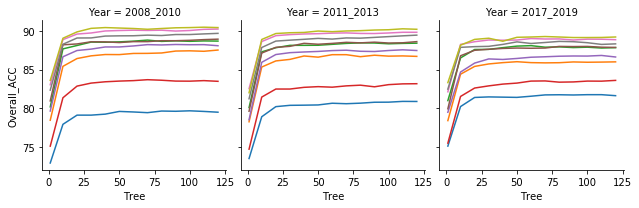

In [14]:
plt.figure(figsize=(10,6))
fig = sns.FacetGrid(data = Full_Percent,col = 'Year',hue='Combo')
fig.map(sns.lineplot,'Tree','Overall_ACC')

In [15]:
Combo_acc_df

,Year,Combo,Percent,Tree,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built
0,2017_2019,Landsat,0,1,86.76,91.68,49.72,93.21,44.22
1,2017_2019,Landsat,0,10,91.26,92.54,77.02,97.83,47.99
2,2017_2019,Landsat,0,20,91.46,92.92,76.32,97.60,51.01
3,2017_2019,Landsat,0,30,91.46,93.05,75.55,97.45,52.01
4,2017_2019,Landsat,0,40,91.26,92.97,74.28,97.29,51.51
...,...,...,...,...,...,...,...,...,...
2803,2008_2010,Landsat_Fourier_Mean,100,80,94.18,91.97,96.49,96.48,92.00
2804,2008_2010,Landsat_Fourier_Mean,100,90,94.24,92.07,96.50,96.48,92.11
2805,2008_2010,Landsat_Fourier_Mean,100,100,94.24,92.01,96.57,96.55,92.03
2806,2008_2010,Landsat_Fourier_Mean,100,110,94.20,91.94,96.56,96.55,91.96


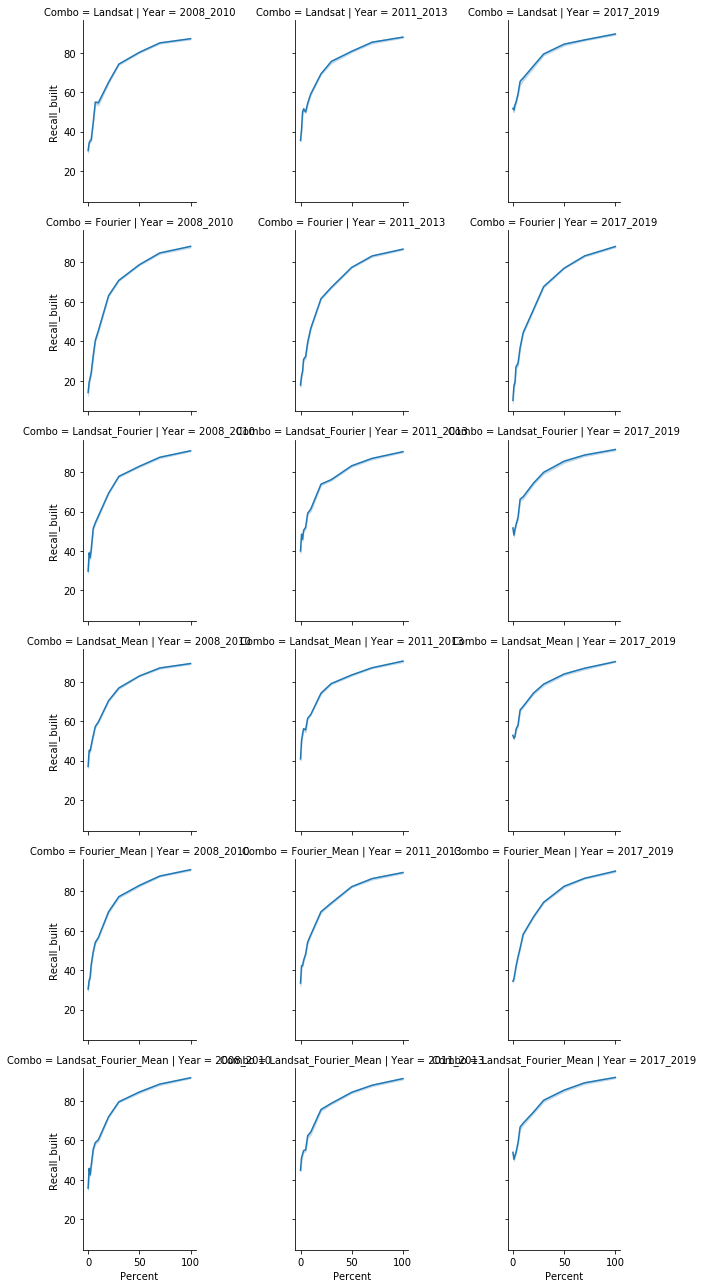

In [16]:
g = sns.FacetGrid(data = Combo_acc_df,row = 'Combo',col='Year')
g.map(sns.lineplot,'Percent','Recall_built')